# Выбор модели и предсказание цены
В данном ноутбуке мы рассмотрим разнные модели машинного обучения, изучим еще раз признаки и то, как они влияют на предсказание цены. По возможнсти сделаем интерпритацию модели и сформируем прогноз цен для тестового набора данных

In [47]:
import pandas as pd
import numpy as np

In [48]:
!pip install pycaret[full]

## Чтение данных

In [49]:
dataset = pd.read_csv('result_dataset.csv')

In [50]:
dataset.head(3)

,product,place,date,amount,price,hot,rain,snow,cost,average_comp_price
0,Целебные травы,Анор Лондо,2216-01-02,37.802874,3.90,1,0,0,2.07,3.9800
1,Эльфийская пыльца,Кеджистан,2216-01-02,53.296328,9.05,0,0,1,4.58,9.2175
2,Эльфийская пыльца,Фалькония,2216-01-02,42.887246,11.32,0,0,0,3.89,11.3100


In [51]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14998 entries, 0 to 14997
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product             14998 non-null  object 
 1   place               14998 non-null  object 
 2   date                14998 non-null  object 
 3   amount              14998 non-null  float64
 4   price               14998 non-null  float64
 5   hot                 14998 non-null  int64  
 6   rain                14998 non-null  int64  
 7   snow                14998 non-null  int64  
 8   cost                14998 non-null  float64
 9   average_comp_price  14998 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 1.1+ MB


Для удобства преобразуем признак `date`

In [52]:
dataset['date'] = pd.to_datetime(dataset['date'])

## Постановка задачи и преобрзование признаков `place`, `product`
Учитывая то, что мы имеем для будущего прогноза только дату, название продукта и название города, то для реализации прогноза построим алгоритм машинного обучения для прогнозирования временного ряда. Используя библиотеку PyCaret, которая предоставляет верхнеуровневые интерфейсы для быстрого изучения и построения различных моделей с их сравнением. Важно отметить, что данная библиотека явялется OpenSource.

В данной задаче нам придется прогнозировать временной ряд отедльно для каждого товара и города. Поэтому для удобства объеденим признаки `place`, `product` в формате `place_product`.

In [53]:
dataset = dataset[['product', 'place', 'price', 'amount', 'date']]

In [54]:
dataset.loc[:, 'place_product'] = dataset[['place', 'product']].apply(lambda x: '_'.join(x) ,axis=1)
dataset.drop(['place', 'product'], axis=1, inplace=True)

In [55]:
dataset.head(3)

,price,amount,date,place_product
0,3.90,37.802874,2216-01-02,Анор Лондо_Целебные травы
1,9.05,53.296328,2216-01-02,Кеджистан_Эльфийская пыльца
2,11.32,42.887246,2216-01-02,Фалькония_Эльфийская пыльца


## Получение дополнительных признаков
Получим из признака `date` следующие признаки:  
* `day_of_week` - день недели
* `year` - год
* `day_of_year` - номер дня в году
* `month` - месяц

In [56]:
dataset['month'] = [i.month for i in dataset['date']]
dataset['year'] = [i.year for i in dataset['date']]
dataset['day_of_week'] = [i.dayofweek for i in dataset['date']]
dataset['day_of_year'] = [i.dayofyear for i in dataset['date']]

dataset.head(3)

,price,amount,date,place_product,month,year,day_of_week,day_of_year
0,3.90,37.802874,2216-01-02,Анор Лондо_Целебные травы,1,2216,1,2
1,9.05,53.296328,2216-01-02,Кеджистан_Эльфийская пыльца,1,2216,1,2
2,11.32,42.887246,2216-01-02,Фалькония_Эльфийская пыльца,1,2216,1,2


In [57]:
dataset['place_product'].nunique()

15

## Moving average

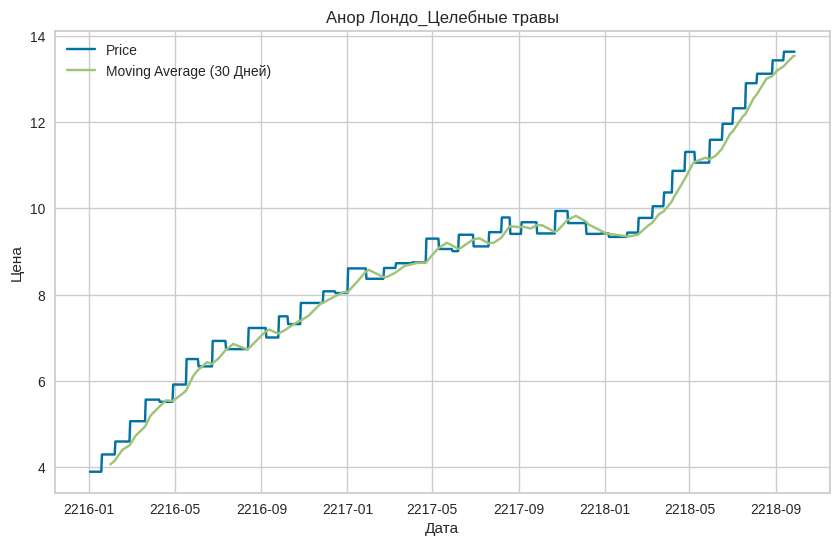

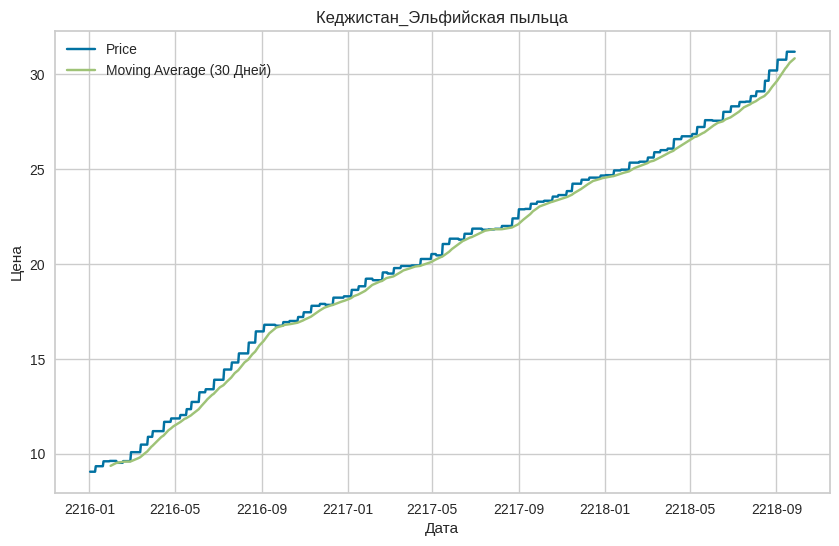

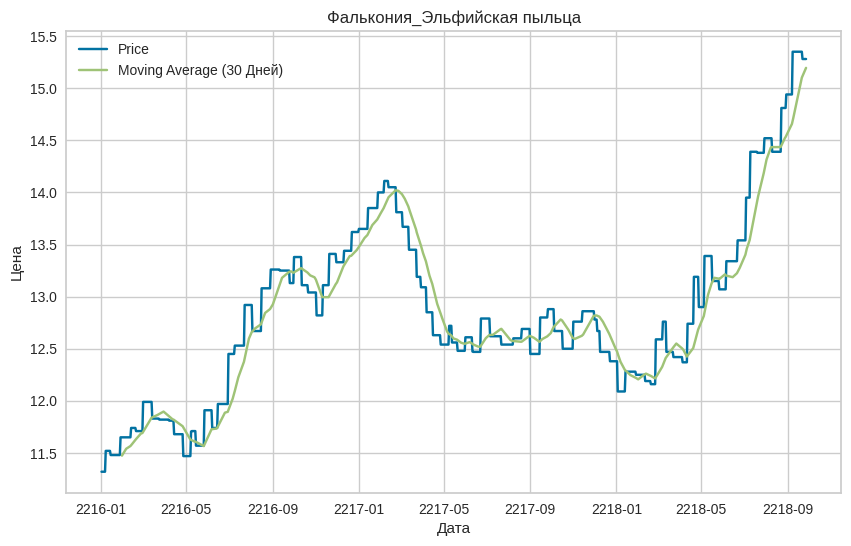

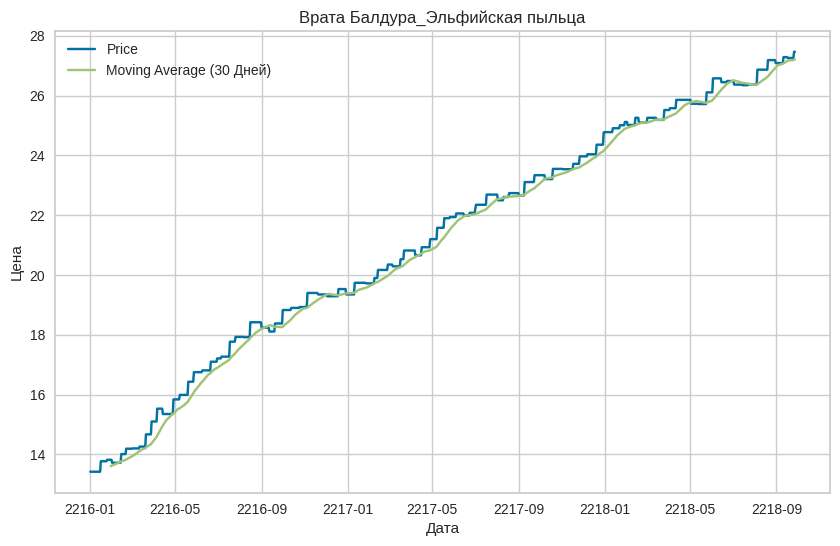

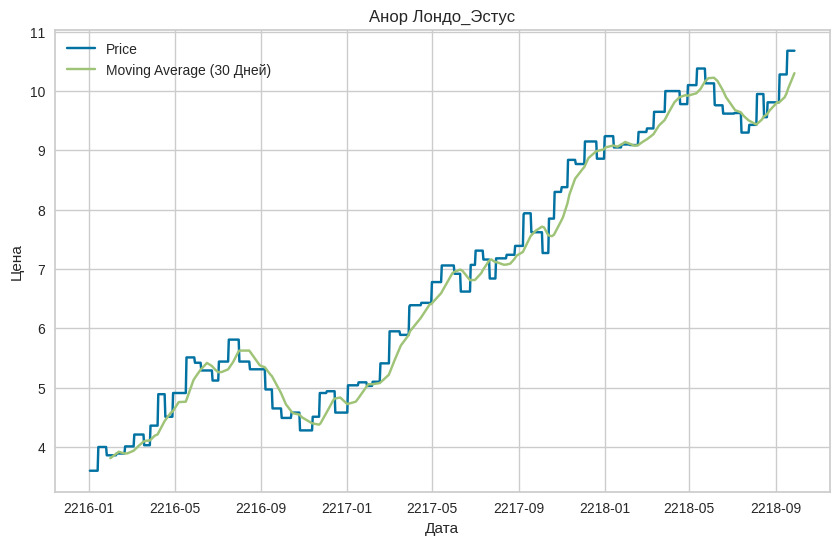

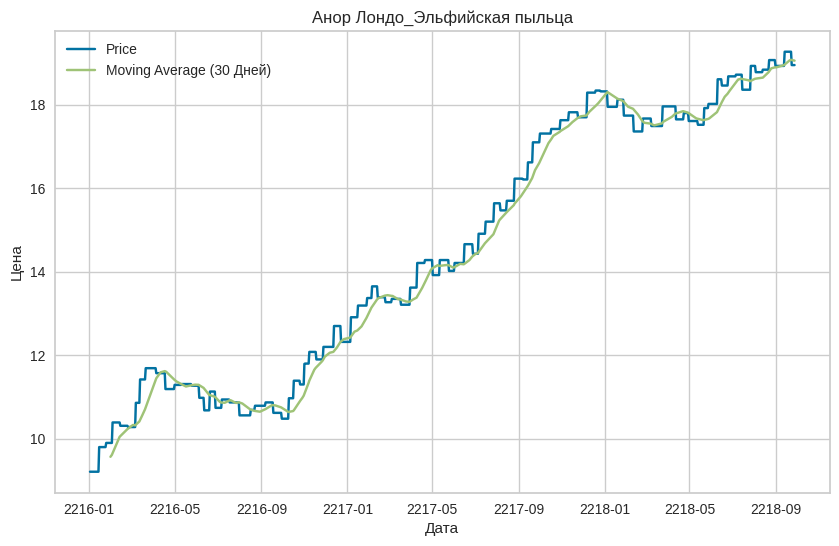

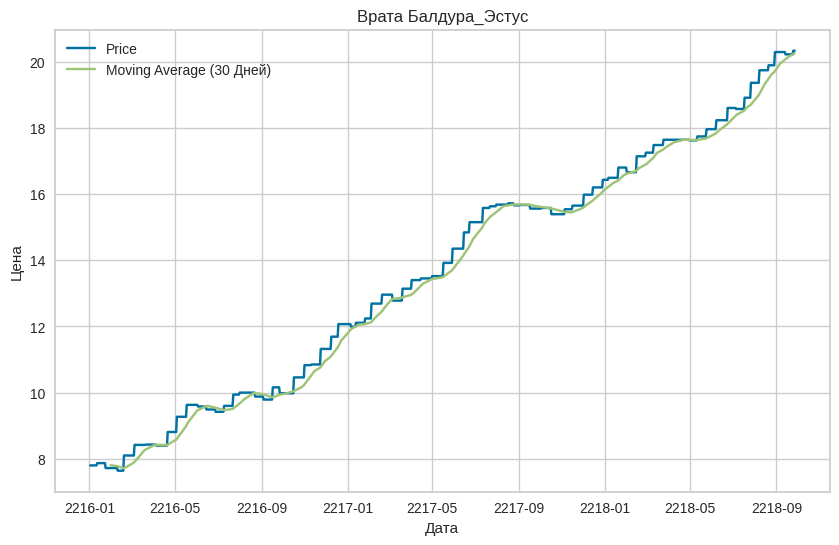

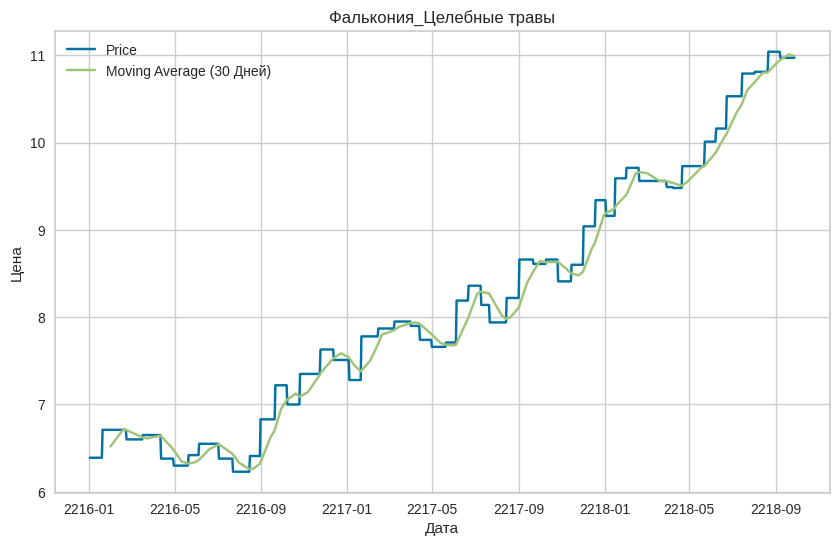

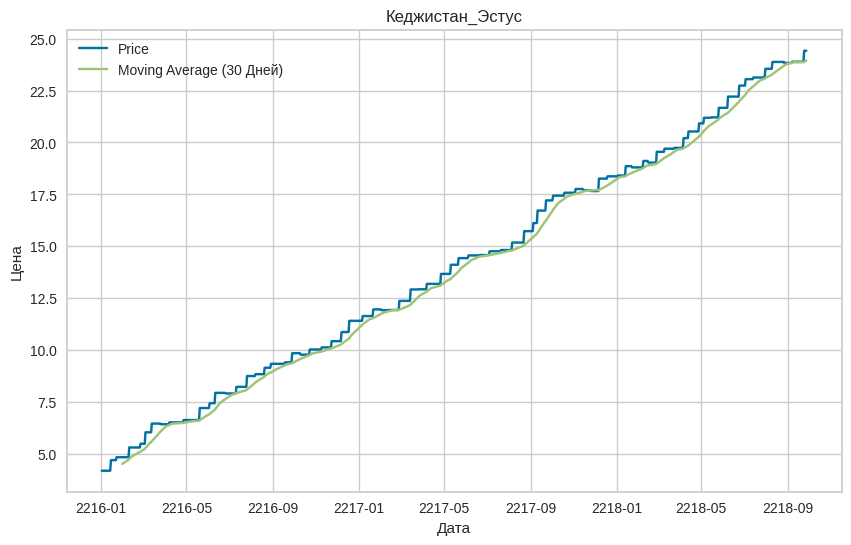

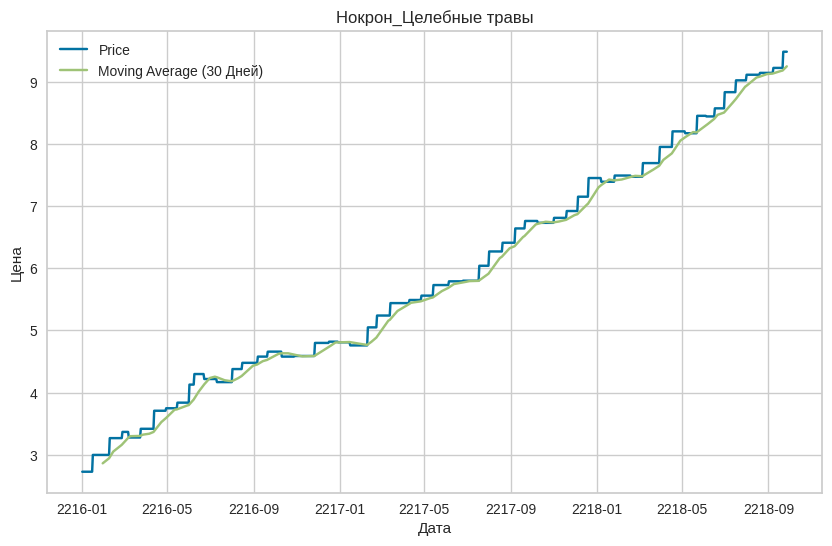

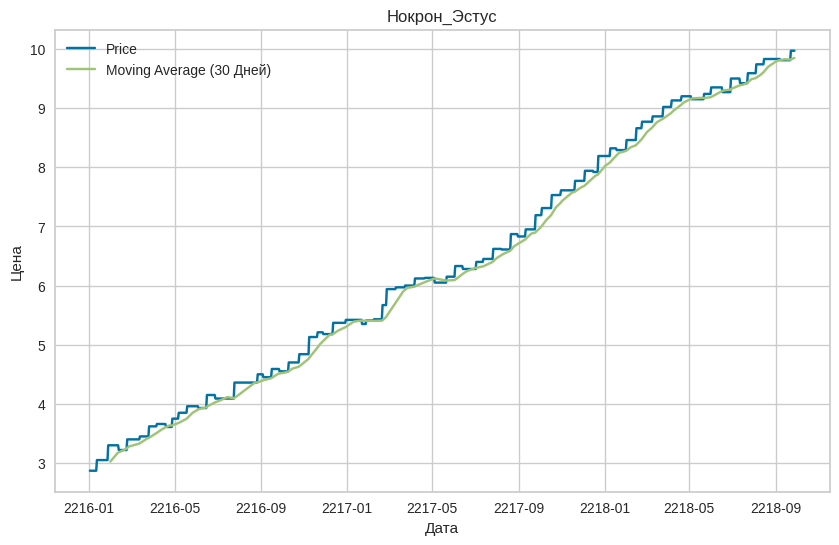

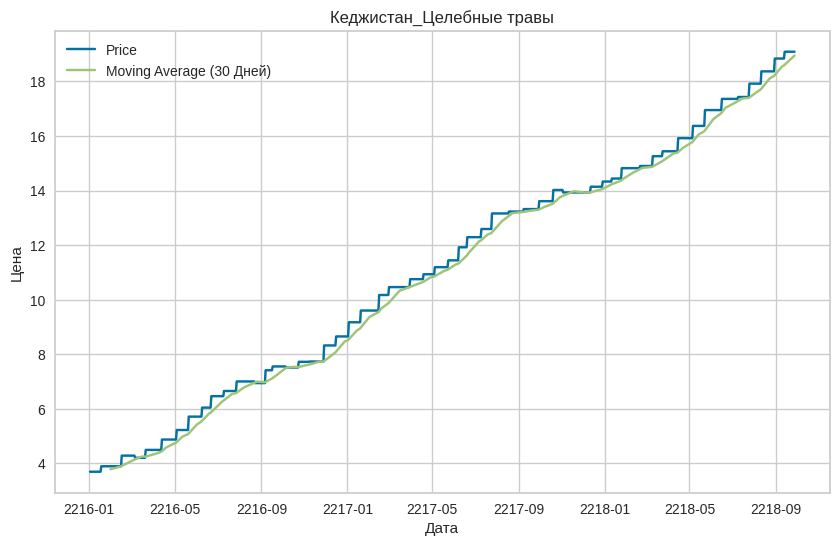

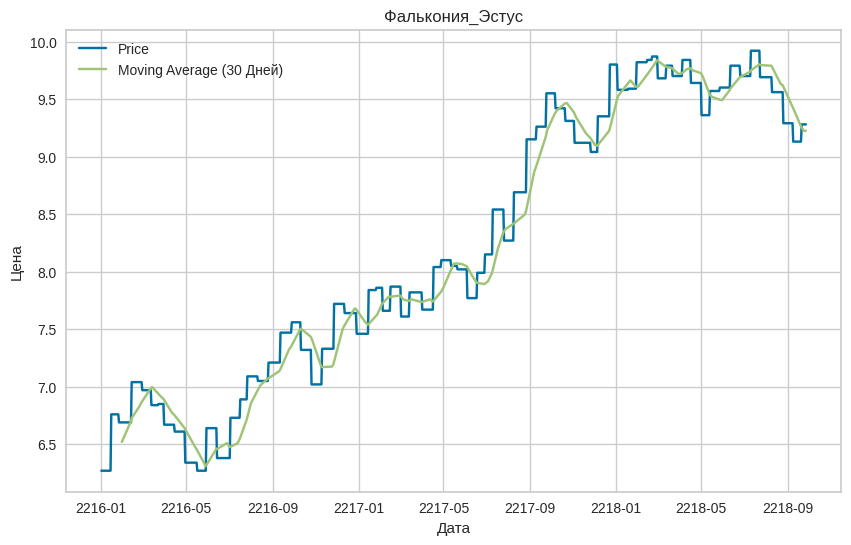

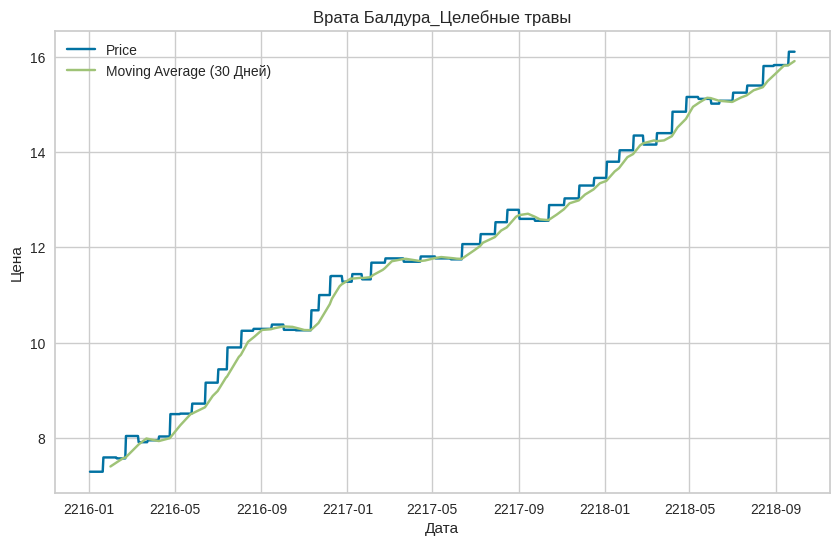

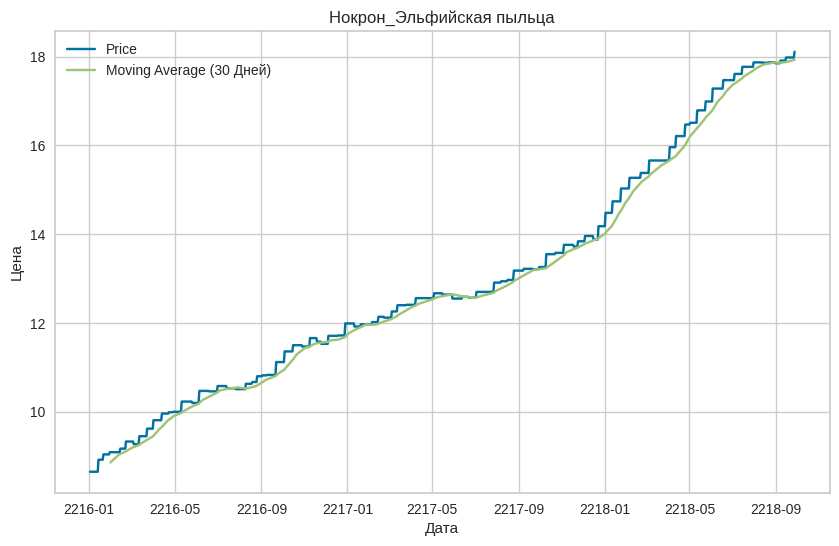

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in dataset['place_product'].unique():
    subset = dataset[dataset['place_product'] == i].copy()
    subset['moving_average'] = subset['price'].rolling(30).mean()

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=subset, x="date", y="price", label="Price")
    sns.lineplot(data=subset, x="date", y="moving_average", label="Moving Average (30 Дней)")

    plt.title(i)
    plt.xlabel("Дата")
    plt.ylabel("Цена")
    plt.legend()
    plt.show()

In [59]:
from tqdm import tqdm
from pycaret.regression import *

all_ts = dataset['place_product'].unique()

all_results = []
final_model = {}

for i in tqdm(all_ts):

    df_subset = dataset[dataset['place_product'] == i]

    s = setup(df_subset, target='price', train_size=0.95,
              data_split_shuffle=False, fold_strategy='timeseries', fold=3,
              ignore_features=['date', 'place_product', 'amount'],
              numeric_features=['day_of_year', 'year'],
              categorical_features=['month', 'day_of_week'],
              verbose=False, session_id=123)

    best_model = compare_models(sort ='MAE', verbose=False)

    p = pull().iloc[0:1]
    p['place_product'] = str(i)
    all_results.append(p)

    f = finalize_model(best_model)

    final_model[i] = f

    save_model(f, model_name='trained_models/' + str(i), verbose=False)

100%|██████████| 15/15 [06:26<00:00, 25.78s/it]


In [60]:
concat_results = pd.concat(all_results,axis=0)
concat_results

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),place_product
omp,Orthogonal Matching Pursuit,1.3696,3.2165,1.6340,-14.1307,0.1838,0.1524,0.3667,Анор Лондо_Целебные травы
ridge,Ridge Regression,2.5619,15.7256,3.2236,-10.4912,0.1821,0.1227,0.1467,Кеджистан_Эльфийская пыльца
en,Elastic Net,0.6243,0.8986,0.8190,-5.6950,0.0591,0.0463,0.1533,Фалькония_Эльфийская пыльца
omp,Orthogonal Matching Pursuit,1.4955,6.0136,1.8720,-9.0145,0.0953,0.0713,0.1533,Врата Балдура_Эльфийская пыльца
lr,Linear Regression,1.1708,1.9097,1.3593,-4.5686,0.1800,0.1784,0.1367,Анор Лондо_Эстус
omp,Orthogonal Matching Pursuit,1.3766,2.9942,1.6391,-2.0957,0.1073,0.0903,0.1567,Анор Лондо_Эльфийская пыльца
omp,Orthogonal Matching Pursuit,1.2657,3.7887,1.6005,-1.9902,0.1244,0.0917,0.1600,Врата Балдура_Эстус
lr,Linear Regression,0.5884,0.5127,0.6846,-2.2088,0.0752,0.0699,0.1533,Фалькония_Целебные травы
omp,Orthogonal Matching Pursuit,1.3781,7.5229,1.8953,-3.7162,0.1830,0.1062,0.1167,Кеджистан_Эстус
omp,Orthogonal Matching Pursuit,0.6226,0.7507,0.7270,-5.3820,0.1198,0.1060,0.1467,Нокрон_Целебные травы


## Создадим датасет для прогнозирования на 90 дней вперед

In [61]:
dataset['date'].max()

Timestamp('2218-09-27 00:00:00')

In [62]:
from datetime import datetime, timedelta

start_date = datetime(2218, 9, 28)

all_dates = [start_date + timedelta(days=i) for i in range(90)]
len(all_dates)

90

In [63]:
score_df = pd.DataFrame()

score_df['date'] = all_dates
score_df['month'] = [i.month for i in score_df['date']]
score_df['year'] = [i.year for i in score_df['date']]
score_df['day_of_week'] = [i.dayofweek for i in score_df['date']]
score_df['day_of_year'] = [i.dayofyear for i in score_df['date']]

score_df.head()

,date,month,year,day_of_week,day_of_year
0,2218-09-28,9,2218,0,271
1,2218-09-29,9,2218,1,272
2,2218-09-30,9,2218,2,273
3,2218-10-01,10,2218,3,274
4,2218-10-02,10,2218,4,275


In [64]:
from pycaret.regression import load_model, predict_model

all_score_df = []

for i in tqdm(dataset['place_product'].unique()):

    loaded_model = load_model('trained_models/' + str(i), verbose=False)
    p = predict_model(loaded_model, data=score_df)
    p['place_product'] = i
    all_score_df.append(p)

concat_df = pd.concat(all_score_df, axis=0)
concat_df.head()

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:00<00:04,  3.36it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.44it/s]

 20%|██        | 3/15 [00:00<00:03,  3.44it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.36it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.34it/s]

 40%|████      | 6/15 [00:01<00:02,  3.34it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.31it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.35it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.37it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.37it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.38it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.39it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.39it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.37it/s]

100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


,date,month,year,day_of_week,day_of_year,prediction_label,place_product
0,2218-09-28,9,2218,0,271,12.641741,Анор Лондо_Целебные травы
1,2218-09-29,9,2218,1,272,12.651158,Анор Лондо_Целебные травы
2,2218-09-30,9,2218,2,273,12.660575,Анор Лондо_Целебные травы
3,2218-10-01,10,2218,3,274,12.669993,Анор Лондо_Целебные травы
4,2218-10-02,10,2218,4,275,12.679410,Анор Лондо_Целебные травы


In [65]:
concat_df.shape

(1350, 7)

In [71]:
concat_df.head()

,date,month,year,day_of_week,day_of_year,prediction_label,place_product
0,2218-09-28,9,2218,0,271,12.641741,Анор Лондо_Целебные травы
1,2218-09-29,9,2218,1,272,12.651158,Анор Лондо_Целебные травы
2,2218-09-30,9,2218,2,273,12.660575,Анор Лондо_Целебные травы
3,2218-10-01,10,2218,3,274,12.669993,Анор Лондо_Целебные травы
4,2218-10-02,10,2218,4,275,12.679410,Анор Лондо_Целебные травы


Учитывая условие задачи о том, что цена должна быть зафикисированна три дни дня, пройдем по данным и установим фикированную стоимость на три дня как среднее этих дней

In [94]:
answer = pd.DataFrame()

for place_product in concat_df['place_product'].unique():
    subset_df = concat_df[concat_df['place_product'] == place_product]

    for i in range(0, subset_df.shape[0], 3):
        subset_df.iloc[i:i+3, 5] = subset_df.iloc[i:i+3, 5].mean()

    answer = pd.concat([answer, subset_df])

In [98]:
answer = answer.reset_index()
answer

,level_0,index,date,month,year,day_of_week,day_of_year,prediction_label,place_product
0,0,0,2218-09-28,9,2218,0,271,12.651158,Анор Лондо_Целебные травы
1,1,1,2218-09-29,9,2218,1,272,12.651158,Анор Лондо_Целебные травы
2,2,2,2218-09-30,9,2218,2,273,12.651158,Анор Лондо_Целебные травы
3,3,3,2218-10-01,10,2218,3,274,12.679410,Анор Лондо_Целебные травы
4,4,4,2218-10-02,10,2218,4,275,12.679410,Анор Лондо_Целебные травы
...,...,...,...,...,...,...,...,...,...
1345,1345,85,2218-12-22,12,2218,1,356,17.970731,Нокрон_Эльфийская пыльца
1346,1346,86,2218-12-23,12,2218,2,357,17.970731,Нокрон_Эльфийская пыльца
1347,1347,87,2218-12-24,12,2218,3,358,17.994322,Нокрон_Эльфийская пыльца
1348,1348,88,2218-12-25,12,2218,4,359,17.994322,Нокрон_Эльфийская пыльца


In [99]:
answer.columns

Index(['level_0', 'index', 'date', 'month', 'year', 'day_of_week',
       'day_of_year', 'prediction_label', 'place_product'],
      dtype='object')

In [100]:
to_drop = ['level_0', 'index', 'month', 'year', 'day_of_week', 'day_of_year']
answer.drop(to_drop, axis=1, inplace=True)

In [102]:
answer['place'] = answer['place_product'].apply(lambda x: x.split('_')[0])
answer['product'] = answer['place_product'].apply(lambda x: x.split('_')[1])

answer.drop('place_product', axis=1, inplace=True)

In [109]:
(answer.loc[0, 'date'] - pd.to_datetime('2218-09-27')).days

1

In [110]:
answer['day_number'] = answer['date'].apply(
    lambda x: (x - pd.to_datetime('2218-09-27')).days
)

In [112]:
answer.rename(columns={'prediction_label': 'price'}, inplace=True)

In [113]:
answer = answer[['day_number', 'product', 'place', 'price']]

answer

,day_number,product,place,price
0,1,Целебные травы,Анор Лондо,12.651158
1,2,Целебные травы,Анор Лондо,12.651158
2,3,Целебные травы,Анор Лондо,12.651158
3,4,Целебные травы,Анор Лондо,12.679410
4,5,Целебные травы,Анор Лондо,12.679410
...,...,...,...,...
1345,86,Эльфийская пыльца,Нокрон,17.970731
1346,87,Эльфийская пыльца,Нокрон,17.970731
1347,88,Эльфийская пыльца,Нокрон,17.994322
1348,89,Эльфийская пыльца,Нокрон,17.994322


In [114]:
answer.to_parquet('solution.parquet', index=False)

In [115]:
pd.read_parquet('solution.parquet')

,day_number,product,place,price
0,1,Целебные травы,Анор Лондо,12.651158
1,2,Целебные травы,Анор Лондо,12.651158
2,3,Целебные травы,Анор Лондо,12.651158
3,4,Целебные травы,Анор Лондо,12.679410
4,5,Целебные травы,Анор Лондо,12.679410
...,...,...,...,...
1345,86,Эльфийская пыльца,Нокрон,17.970731
1346,87,Эльфийская пыльца,Нокрон,17.970731
1347,88,Эльфийская пыльца,Нокрон,17.994322
1348,89,Эльфийская пыльца,Нокрон,17.994322
